# Modelos individuais

* Modelos onde cada indivíduo é tratado como uma variável, com características próprias.

* Podem ser mapeamentos (discretos no tempo) ou sistemas de equações diferenciais (contínuos no tempo). 

* Podem ser determinísticos ou estocásticos.

* Vamos ver, concretamente, um modelo individual discreto estocástico.

In [1]:
using LinearAlgebra
using Random
using StatsBase
using Plots

## Cenário

* Criamos um "cenário", com um determinado número `N` de indivíduos e vetores de comprimento `N` com os atributos de cada indivíduo.

* Há várias formas de se fazer isso, dependendo do nível de detalhamento que queiramos fazer.

* Podemos determinar a idade de cada indivíduo, o grau de suscetibilidade e de infectividade de cada indivíduo, a posição espacial onde o indivíduo se encontra em cada instante, etc..

* No exemplo a seguir, vamos considerar, apenas, graus de suscetibilidade e de infectividade.

* Além disso, precisamos de um vetor indicando o estágio, ou estado, da doença em cada indivíduo.

### Atributos

* Vamos definir, então, um vetor `estado`, onde cada elemento do vetor representa o estágio epidemiológico de cada indivíduo. Vamos considerar, a título de exemplo, três possíveis estados: **suscetível,** **infectado** e **recuperado**. Vamos representá-los, no vetor, pelos inteiros `0`, `1` e `2`, respectivamente.

* O grau de suscetibilidade de cada indivíduo é representado por um real positivo. Isso será representado por um vetor `suscetibilidade` de números em ponto flutuante. Há estudos indicando que esse grau segue uma distribuição beta, na população. Para simplificar, vamos apenas usar uma distribuição uniforme entre dois números positivos.

* Idem para o vetor `infectividade`.

* Da mesma forma, consideramos um vetor `recuperacao`, indicando a taxa de recuperação de cada indivíduo, no caso dele vir a ser infectados. Vamos considerar essa atributo correlacionado ao atributo de suscetibilidade.

### Parâmetros epidemiológicos globais

* Em relação aos outros parâmetros epidemiológicos, consideramos os seguintes.

* Uma taxa $\tau$ de contágios por contato próximo.

* Uma taxa média $\kappa$ de número de contatos próximos por indivíduo.

In [2]:
# Cenário

N = 10_000 # população
estado = zeros(Int,N)
infectividade = 0.5 .+ rand(N)
suscetibilidade = 0.5 .+ rand(N)
recuperacao = 1 ./ (1 .+ 9 * rand(N)) # distribuição uniforme entre 1 e 10 dias de recuperação
recuperacao = 1 ./ (1 .+ 6 * rand(N) .* suscetibilidade) # distribuição entre 1 e 9, correlacionada com a suscetibilidade
nothing

In [3]:
τ = 0.02 # taxa de contágio por contato próximo
κ = 20 # número médio de contatos por indivíduo
nothing

## Dinâmica da epidemia

* Este é um modelo SIR individual.

* Cada indivíduo suscetível pode se tornar infectado através do contato com indivíduos infectados.

* E cada indivíduo infectado se recupera de acordo com a sua taxa de recuperação.

* Este é um modelo discreto no tempo, com cada iteração correspondendo a um dia de evolução.

* Também é um modelo estocástico. A cada passo de tempo, cada indivíduo suscetível *pode* se tornar infectado dependendo de um número sorteado aleatoriamente ser maior ou não do que a *força de infecção* agindo no indivíduo, ponderada pelo grau de suscetibilidade do indivíduo.

* E cada indivíduo infectado *pode* se recuperar dependendo de um número sorteado aleatoriamente ser menor ou não do que a taxa de recuperação do indivíduo.

### Força de infecção

* A força de infecção $\lambda$ de um indivíduo é calculada de acordo com o grau de infectividade dos indivíduos infectados que tenham tido contato com o indivíduo em questão.

* No caso compartimental, temos $\lambda \sim \beta I / N = \kappa \tau I / N$, onde $\kappa$ é o número médio de contatos por indivíduo e $I / N$ é a fração desses que é de contatos com infectados. No caso individual, o número de contatos $\kappa = \kappa_i$ é individualizado e a fração $I/N$ de contatos infectados é $\sum_j I_j / \kappa_j$, onde $I_j$ indica a infectividade (ou é zero se o $j$-ésimo contato não está infectado). Logo, o termo $\kappa_j$ (está implícito) se cancela e ficamos com
$$
\lambda = \tau * \sum_{\textrm{contatos com infectados j}} \mathrm{infectividade}[j].
$$

* No caso contínuo no tempo, temos $S' = - \lambda S$, o que nos dá, num intervalo de tempo $\Delta t$,
$$
S(t + \Delta t) = S(t) e^{-\lambda \Delta t}.
$$

* Assim, no caso discreto no tempo, a taxa de variação de suscetíveis/infectados é proporcional à
$$
e^{-\lambda \Delta t}
$$

* Quando maior $\lambda$, menor $e^{-\lambda \Delta t}$ e maior a probabilidade de um determinado indivíduo suscetível se tornar infectado.

* No caso estocástico discreto, isso é alcançado sorteando-se, para cada indivíduo suscetível, um número aleatório uniformemente entre zero e um e verificando se esse número é maior do que $e^{-\lambda \Delta t}$ ou não. Caso positivo, o indivíduo se torna infectado. Caso contrário, permanece suscetível.

### Recuperação

* Da mesma forma, no caso compartimental contínuo, a recuperação é determinada pela componente $I' = - \gamma I$.

* Após um tempo $\Delta t$, temos uma variação no número de infectados, por conta da recuperação, da ordem de
$$
I(t + \Delta t) = I(t) e^{-\gamma \Delta t}.
$$

* No caso temporal discreto, vemos que a recuperação, a cada passo de tempo $\Delta t$, é proporcional a um fator dependente da taxa de recuperação $\gamma_i$ de cada indivíduo:
$$
e^{-\gamma_i \Delta t}.
$$

* Quanto maior a taxa de recuperação $\gamma_i$, maiores as chances do indivíduo se recuperar.

* Na simulação, sorteamos, então, um número aleatório $r$ distribuído uniformemente entre $0$ e $1$ e vericamos se este número é maior ou menor do que $e^{-\gamma_i \Delta t}$. Caso positivo, o indivíduo se recupera, caso contrário, permanece infectado.

### Contatos

* Os contatos entre os indivíduos são definidos aleatoriamente a cada passo. Há várias estruturas que podemos usar (aglomerados residenciais, aglomerados escolares, aglomerados em postos de trabalho, redes de contato entre amigos, encontros aleatórios entre a população em geral - e.g. em meios de transporte, lojas de comércio, parques, shows, etc.).

* Para simplificar, no entanto, vamos considerar, apenas, aglomerados arbitrários sorteados a cada passo de tempo.

## Quantidades de interesse

* Para simplificar, não vamos guardar o histórico de cada indivíduo. O vetor com o estado epidemiológico da população será atualizado a cada passo de tempo.

* Vamos guardar o histórico, apenas, do total de indivíduos em cada estágio epidemiológico.

## Simulação

* Abaixo implementamos o modelo descrito acima.

In [4]:
# Evolução
num_dias = 180 # número (inteiro) de dias
passos_dias = 4 # número (inteiro) de passos por dia
dt = 1/passos_dias # tamanho do passo
len_tempos = passos_dias * num_dias + 1 # tamanho malha temporal
tempos = range(0.0, num_dias, length = len_tempos) # malha temporal, começando com tempos[1] = 0 e terminando em tempos[end] = float(num_dias)

# inicialização
ninf0 = 5 # número inicial de infectados
inf0 = sample(1:N, ninf0) # seleção aleatória dos infectados
estado = zeros(Int, N) # inicialização da população como todos suscetíveis
estado[inf0] .= 1 # infectados iniciais

# compartimentos
suscetiveis = zeros(Int, len_tempos)
infectados = zeros(Int, len_tempos)
recuperados = zeros(Int, len_tempos)
suscetiveis[1] = count(estado .== 0)
infectados[1] = count(estado .== 1)
recuperados[1] = count(estado .== 2)

# força de infecção
λ = zeros(N)

# contatos
contatos = collect(1:N)

# evolução
for n in 2:len_tempos
    λ .= 0.0
    if rem(n, passos_dias) == 0 # shuffle once a day
        shuffle!(contatos)
    end
    i = 1
    while i ≤ N
        ip = min(i + rand(div(κ, 2):2κ), N)
        if any(==(1), estado[contatos[i:ip]])
            λ[contatos[i:ip]] .= τ * sum(infectividade[contatos[j]] for j in i:ip if estado[contatos[j]] == 1)
        end
        i = ip + 1
    end
    for i in 1:N
        if estado[i] == 0 && rand() > exp(-λ[i] * dt)
            estado[i] = 1
        elseif estado[i] == 1 && rand() > exp(-recuperacao[i] * dt)
            estado[i] = 2
        end        
    end
    suscetiveis[n] = count(estado .== 0) # contabiliza compartimento suscetíveis
    infectados[n] = count(estado .== 1) # contabiliza compartimento infectados
    recuperados[n] = count(estado .== 2) # contabiliza compartimento recuperados
end

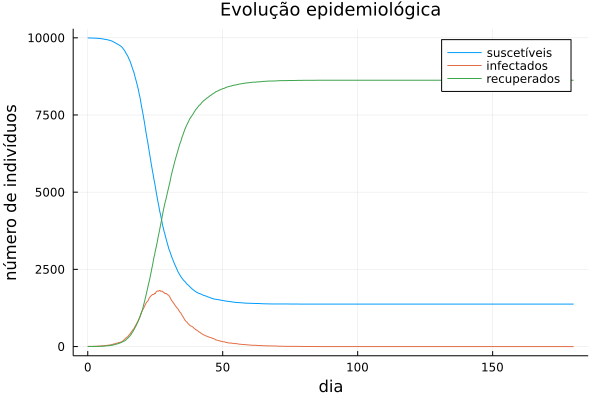

In [5]:
plot(title = "Evolução epidemiológica", titlefont = 12, xaxis = "dia", yaxis = "número de indivíduos")
plot!(tempos, suscetiveis, label = "suscetíveis")
plot!(tempos, infectados, label = "infectados")
plot!(tempos, recuperados, label = "recuperados")

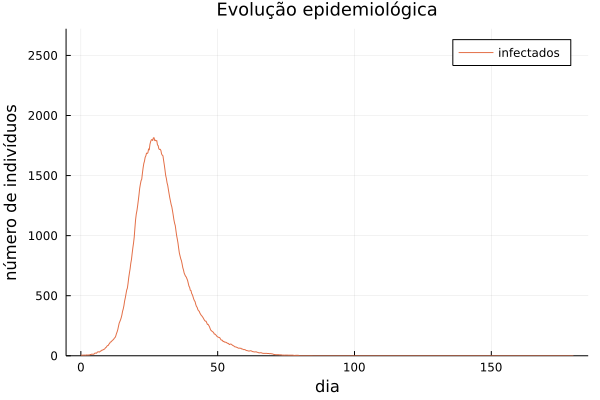

In [6]:
plot(title = "Evolução epidemiológica", titlefont = 12, xaxis = "dia", yaxis = "número de indivíduos")
plot!(tempos, infectados, ylim = (0.0, min(1.5 * maximum(infectados), N)), label = "infectados", color = 2)

## Exercícios

1. Implemente uma versão SEIR do modelo individual discreto estocástico descrito acima.



## Referências

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)